In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from pandas import datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm import tqdm_notebook
from itertools import product
import scipy.stats as scs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if sys.path[0] == '':


In [2]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이터/찐최종 데이터/구글클라우드플랫폼/seoul_final.csv',
                    encoding = 'UTF-8')

In [3]:
data

,Unnamed: 0,date,add,ca,avg_ta,sum_rn,new_wd,new_ws
0,1,2012-01-01,서울,5.1,-2.7,0.0,-606.6210,-9.6589
1,2,2012-01-02,서울,2.9,-4.6,0.0,-501.4768,-5.1131
2,3,2012-01-03,서울,7.5,-4.3,0.0,-607.3124,-7.7681
3,4,2012-01-04,서울,1.1,-6.8,0.0,-613.9938,-7.9552
4,5,2012-01-05,서울,0.0,-5.2,0.0,-581.0362,-5.4605
...,...,...,...,...,...,...,...,...
3952,3953,2022-10-27,서울,1.4,13.1,0.0,-535.2946,-5.5603
3953,3954,2022-10-28,서울,1.5,13.2,0.0,-284.1164,-4.6625
3954,3955,2022-10-29,서울,1.1,14.1,0.0,-165.0994,-4.6590
3955,3956,2022-10-30,서울,1.1,14.2,0.0,-184.9884,-4.7077


# **기온**

In [4]:
temp = data[['date', 'avg_ta']]

In [5]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3957 entries, 0 to 3956
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3957 non-null   object 
 1   avg_ta  3957 non-null   float64
dtypes: float64(1), object(1)
memory usage: 62.0+ KB


In [6]:
temp['date'] = pd.to_datetime(temp['date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


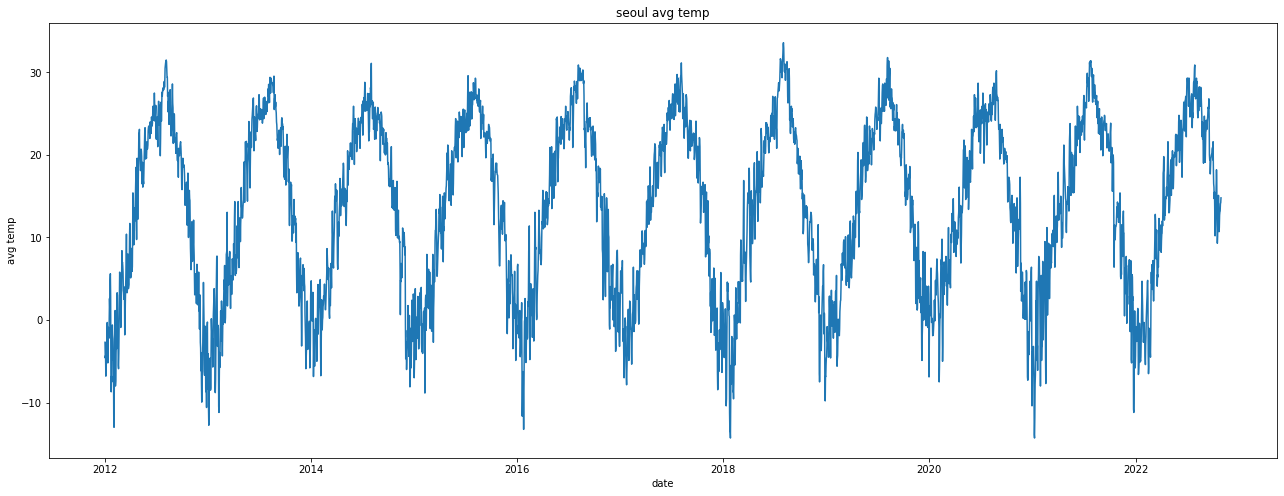

In [8]:
#시계열 그래프
plt.figure(figsize=(22,8))
plt.plot(temp['date'], temp['avg_ta'])
plt.title('seoul avg temp')
plt.xlabel('date')
plt.ylabel('avg temp')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


<Figure size 432x288 with 0 Axes>

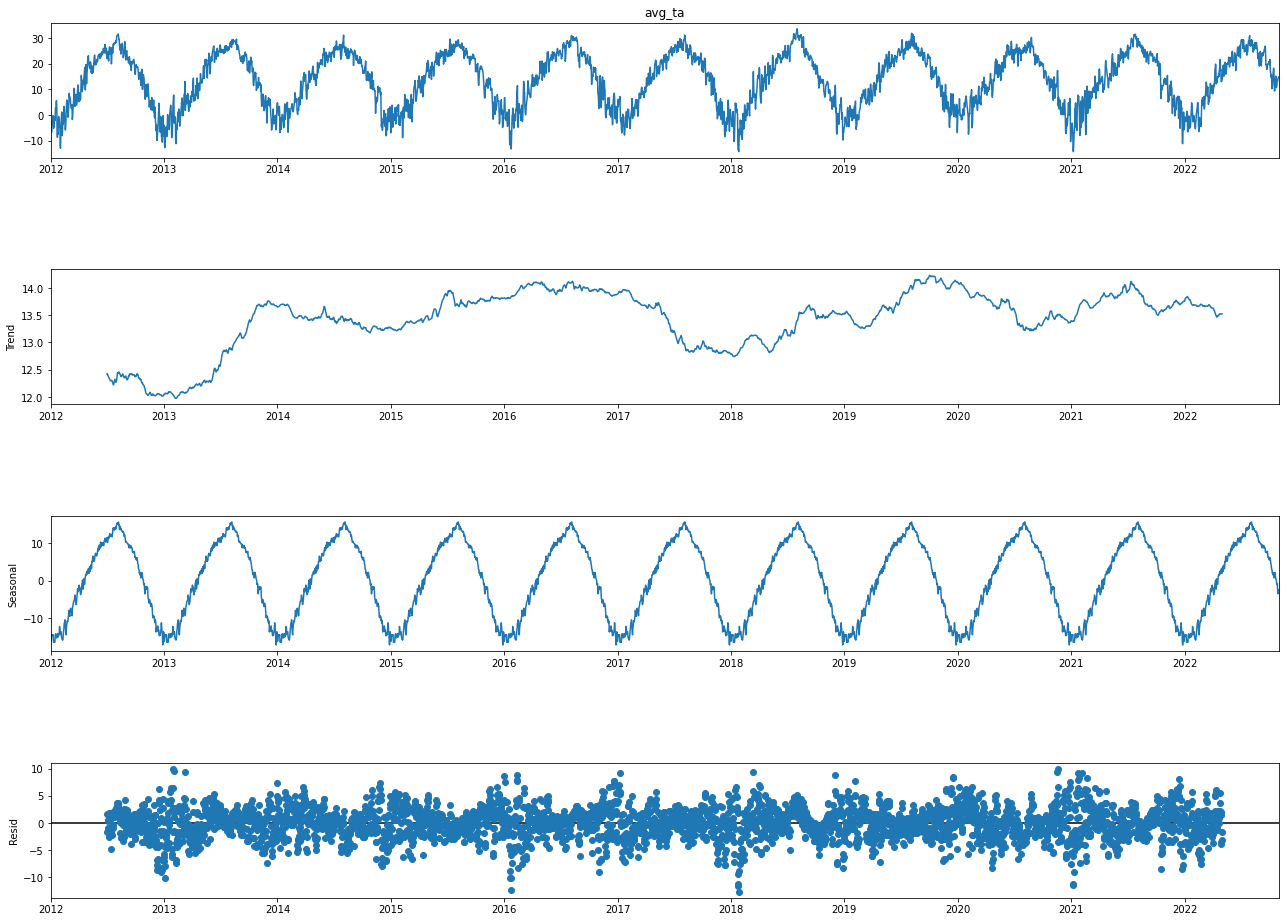

In [9]:
#시계열 분해법
ts = temp.loc[:,['date', 'avg_ta']]
ts.index = ts['date']
ts = ts.drop('date', axis = 1)

result = seasonal_decompose(ts['avg_ta'], model = 'additive', freq = 365)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

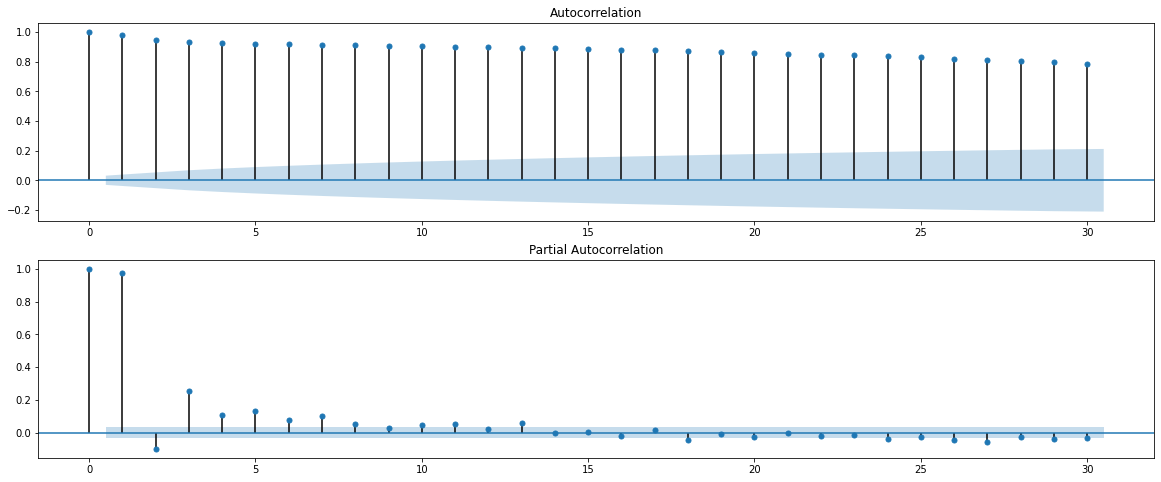

In [12]:
#차분 전 ACF, PACF 그래프
fig = plt.figure(figsize = (20,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig1 = sm.graphics.tsa.plot_acf(ts, lags = 30, ax = ax1)
fig2 = sm.graphics.tsa.plot_pacf(ts, lags = 30, ax = ax2)

#ACF: 1이후 절단
#PACF: 1이후 절단

In [13]:
#단위근 검정
from statsmodels.tsa.stattools import adfuller

result2 = adfuller(ts, autolag = 'AIC')
print('ADF Statistic : %f' %result2[0])
print('p_value: %f' %result2[1])
print('n_lags: %f' %result2[2])
print('Critical Values:')
for key, value in result2[4].items():
  print('\t%s: %.3f' %(key, value))

ADF Statistic : -4.877037
p_value: 0.000039
n_lags: 31.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [15]:
def kpss_test(timeseries, pvalue = .05, regression_option = 'ct'):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression= regression_option)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    if kpss_output[1] < pvalue:
        print(f"정상시계열이 맞다는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성을 보장하지 못합니다.")
    else:
        print(f"정상시계열이 맞다는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.")
        

kpss_test(temp['avg_ta'])

Results of KPSS Test:
Test Statistic            0.035111
p-value                   0.100000
Lags Used                31.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [ ]:
rain = data[['date', 'sum_rn']]

In [ ]:
rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3957 entries, 0 to 3956
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3957 non-null   object 
 1   sum_rn  3957 non-null   float64
dtypes: float64(1), object(1)
memory usage: 62.0+ KB


In [ ]:
rain['date'] = pd.to_datetime(rain['date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train = rain.loc[rain.date <= '2020-12-31',:]
valid = rain.loc['2020-12-31' < rain.date,:]
valid = valid.loc[valid.date <= '2021-12-31',:]
test = rain.loc[rain.date > '2021-12-31',:]
print(train.shape, valid.shape, test.shape)

(3288, 2) (365, 2) (304, 2)


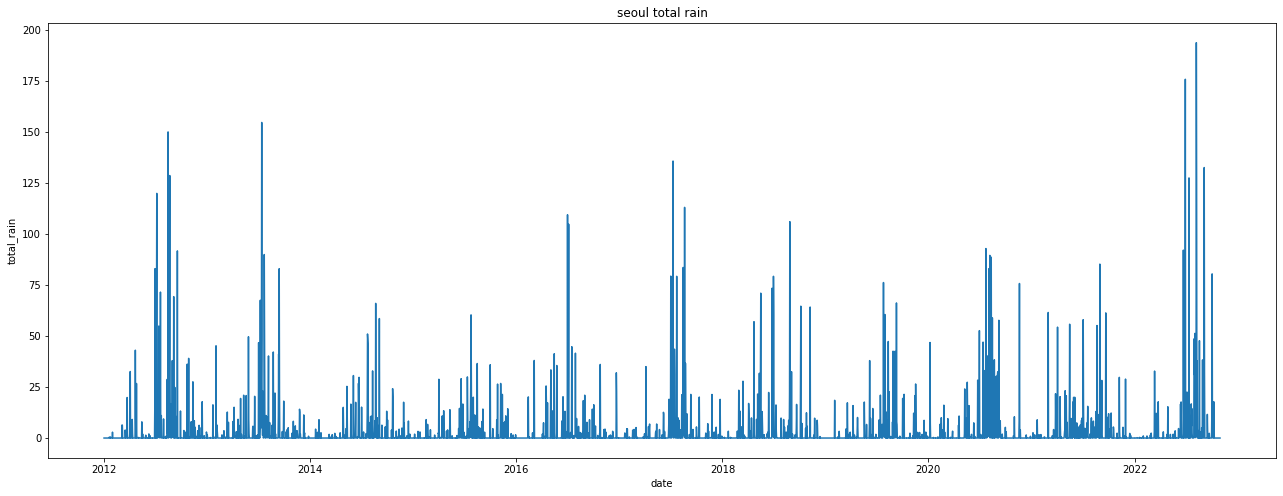

In [ ]:
#시계열 그래프
plt.figure(figsize=(22,8))
plt.plot(rain['date'], rain['sum_rn'])
plt.title('seoul total rain')
plt.xlabel('date')
plt.ylabel('total_rain')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


<Figure size 432x288 with 0 Axes>

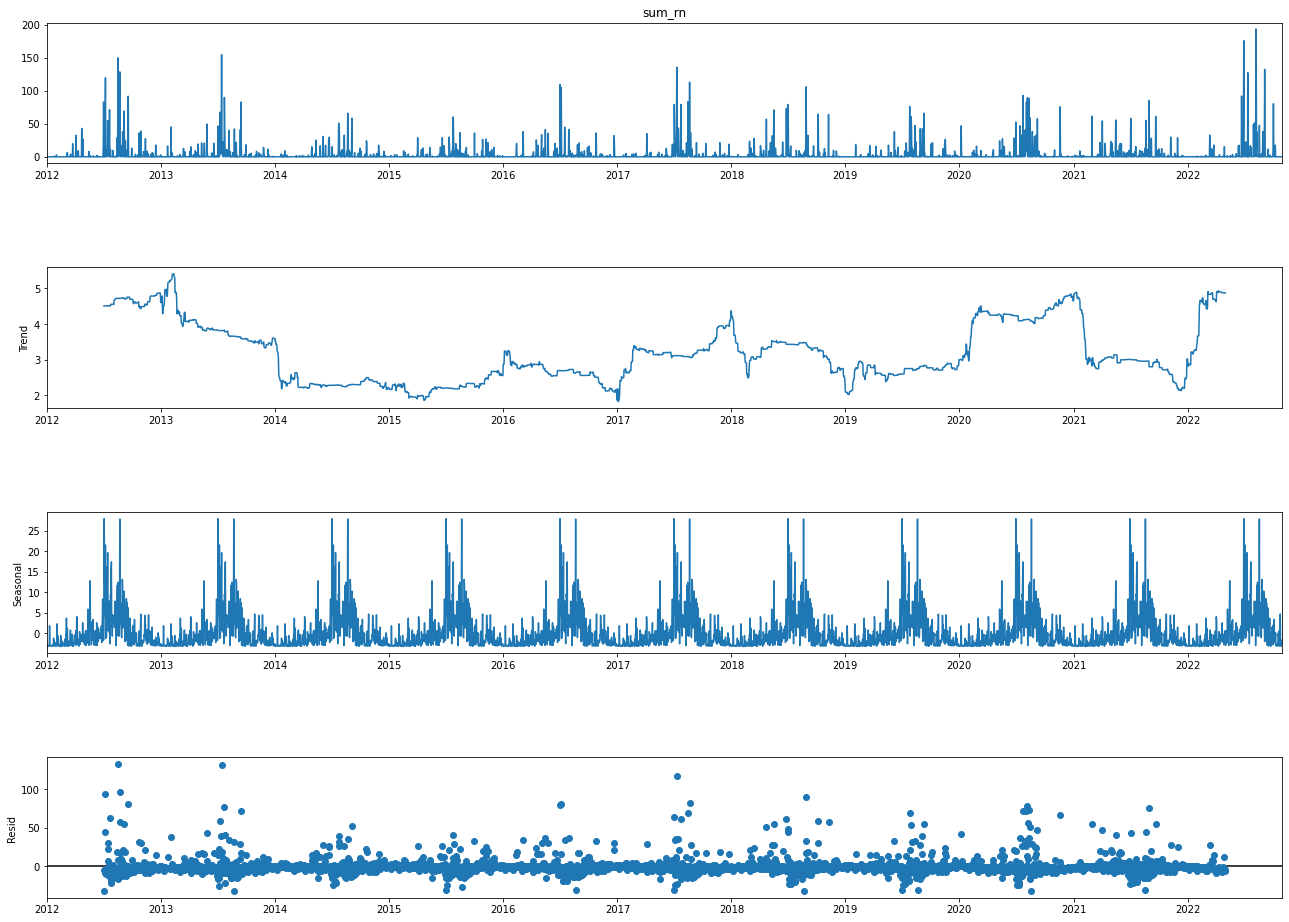

In [ ]:
#시계열 분해법
ts = rain.loc[:,['date', 'sum_rn']]
ts.index = ts['date']
ts = ts.drop('date', axis = 1)

result = seasonal_decompose(ts['sum_rn'], model = 'additive', freq = 365)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

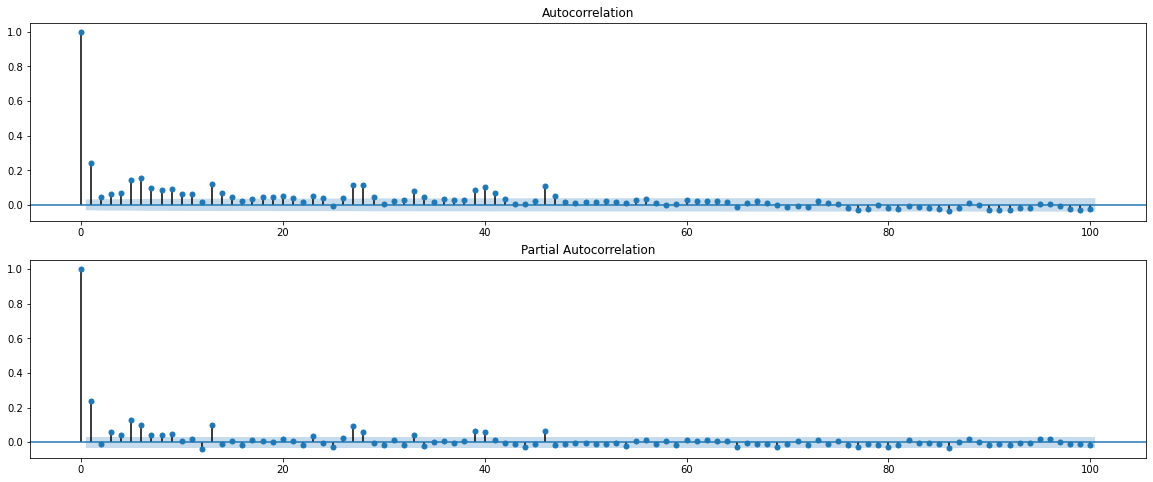

In [ ]:
#차분 전 ACF, PACF 그래프
fig = plt.figure(figsize = (20,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig1 = sm.graphics.tsa.plot_acf(ts, lags = 100, ax = ax1)
fig2 = sm.graphics.tsa.plot_pacf(ts, lags = 100, ax = ax2)

#ACF: 1이후 절단
#PACF: 1이후 절단

In [ ]:
def tsplot(y, lags=None, figsize=(13, 8), style='bmh', title="Time Series Analysis Plots"):
    y = y.values
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    if not isinstance(title, str):
        title = str(title)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        _ = plt.xticks(np.arange(0, len(y), step=24))
        
        acf_ax = plt.subplot2grid(layout, (1, 0))
        _ = plt.xticks(np.arange(0, len(y), step=24)) 
        
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        _ = plt.xticks(np.arange(0, len(y), step=24)) 
        
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
 
    return plt.show()

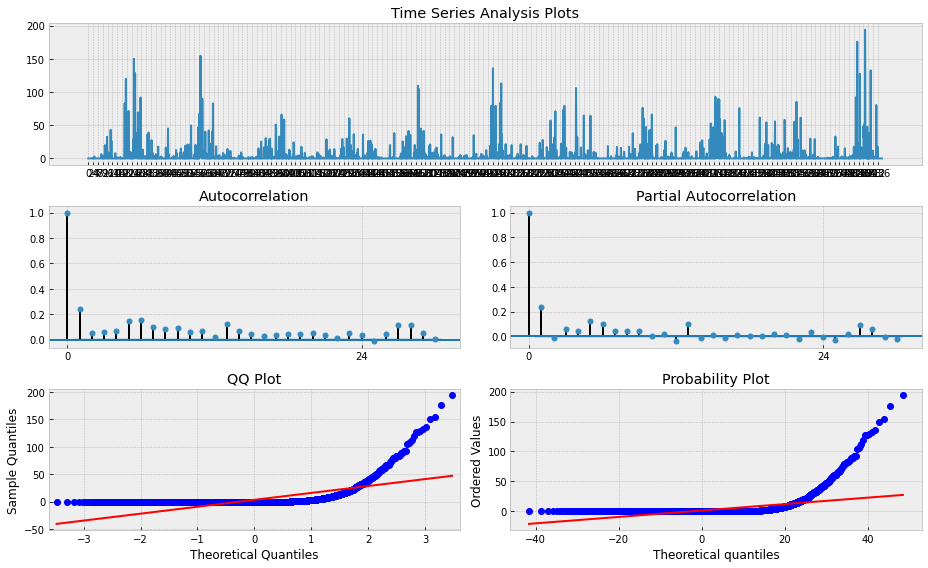

In [ ]:
tsplot(rain['sum_rn'], lags = 30)

In [ ]:
log_ts = np.log(ts+1) - np.mean(np.log(ts+1))

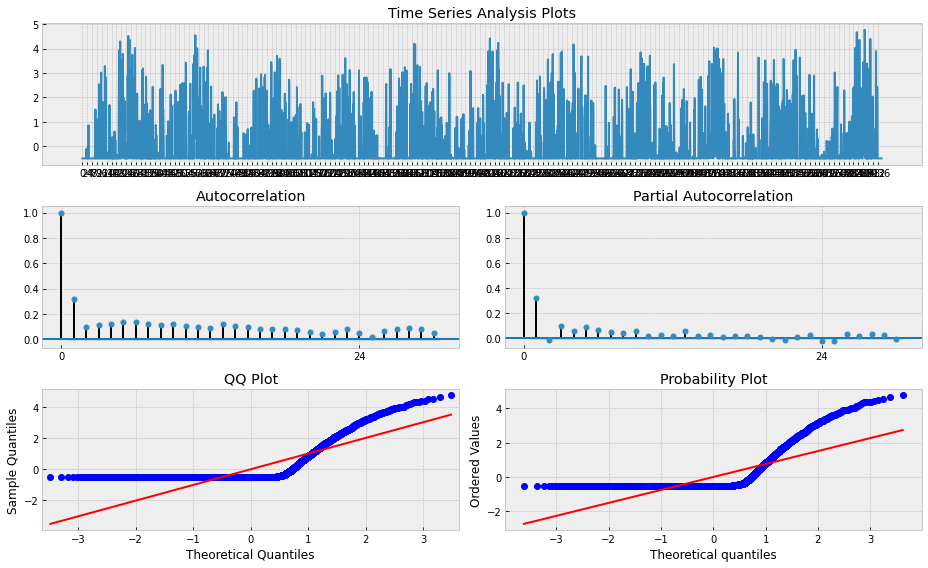

In [ ]:
tsplot(log_ts['sum_rn'], lags = 30)

In [ ]:
ARMA()

In [ ]:
sarima_order=[1,0,1]
sarima_seasonal_order=[1,0,1,365]

model = SARIMAX(endog = rain['sum_rn'], order=sarima_order, seasonal_order=sarima_seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False).fit()

KeyboardInterrupt: ignored

In [ ]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             sum_rn   No. Observations:                 3957
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood              -15499.762
Date:                            Sat, 12 Nov 2022   AIC                          31009.525
Time:                                    06:18:47   BIC                          31040.923
Sample:                                         0   HQIC                         31020.663
                                           - 3957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2271      0.057      3.978      0.000       0.115       0.339
ma.L1          0.0135      0.058   

In [ ]:
pred = model.get_prediction(start = pd.to_datetime('2022-01-01'),
                            end = pd.to_datetime('2022-12-31'), dynamic = True)

KeyError: ignored

In [ ]:
#단위근 검정
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(rain['sum_rn'])

Results of Dickey-Fuller Test:
Test Statistic                -8.024158e+00
p-value                        2.038507e-12
#Lags Used                     2.700000e+01
Number of Observations Used    3.929000e+03
Critical Value (1%)           -3.432015e+00
Critical Value (5%)           -2.862276e+00
Critical Value (10%)          -2.567162e+00
dtype: float64


In [ ]:
rain_ts_diff = (train.values -train.values.shift(2))

array([[Timestamp('2012-01-01 00:00:00'), 0.0],
       [Timestamp('2012-01-02 00:00:00'), 0.0],
       [Timestamp('2012-01-03 00:00:00'), 0.0],
       ...,
       [Timestamp('2020-12-29 00:00:00'), 0.006896552],
       [Timestamp('2020-12-30 00:00:00'), 0.0],
       [Timestamp('2020-12-31 00:00:00'), 0.0]], dtype=object)

In [ ]:
import itertools

p = d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

for param in pdq :
  for param_seasonal in seasonal_pdq :
    try:
      tmp_mdl = sm.tsa.statespace.SARIMAX(train['sum_rn'], exog = None, 
                                          order = param, seasonal_order = param_seasonal,
                                          enforce_stationarity = True,
                                          enforce_invertibility = True)
      res = tmp.mdl.fit()
      print('SARIMAX{}x{}12 - AIC : {}'.format(param, param_seasonal, res.aic))

      if res.aic < best_aic :
        besT_aic = res.aic
        best_pdq = param
        best_seasonal_pdq = param_seasonal
        best_mdl = tmp_mdl

    except :
      continue
      
print('best SARIMAX{}x{}12 - AIC : {}'.format(best_pdq, best_seasonal_pdq, best_aic))

best SARIMAXNonexNone12 - AIC : inf


In [ ]:
#SARIMA model
def optimize_SARIMA(parameters_list, d, D, s, exog):    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
# 파라미터 조합 리스트 
p = range(0, 3, 1) #pacf에서 수렴하기 직전값
d = 0 #추세 존재 여부
q = range(0, 3, 1) #adf테스트 및 추세 확인
P = range(0, 2, 1) #pacf에서 계절성이 주기 반복횟수
D = 1 #계절성 존재 여부
Q = range(0, 2, 1) #acf기준 계절성 주기 반복횟수
s = 12 #계절성 주기
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

36


In [ ]:
result_df = optimize_SARIMA(parameters_list, 0, 1, 12, train['sum_rn'])
result_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

,"(p,q)x(P,Q)",AIC
0,"(2, 2, 1, 1)",25160.062696
1,"(1, 2, 1, 1)",25166.467998
2,"(2, 2, 0, 1)",25169.847187
3,"(1, 2, 0, 1)",25175.277445
4,"(2, 1, 1, 1)",25176.722725
5,"(2, 1, 0, 1)",25185.285906
6,"(1, 0, 0, 1)",25274.802039
7,"(1, 0, 1, 1)",25276.429463
8,"(1, 1, 0, 1)",25276.751831
9,"(2, 0, 0, 1)",25276.777442


In [ ]:
#가장 aic 낮은 파라미터 모델 적합 (p, d, q) (P, D, Q, s) 
best_model = SARIMAX(train['sum_rn'], order=(2, 0, 2), seasonal_order=(0, 1, 1, 12), enforce_stationarity=True, enforce_invertibility=True)
res = best_model.fit()
print(res.summary())

In [ ]:
pip install armagarch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import armagarch as ag
import pandas_datareader as web
import matplotlib.pyplot as plt
import numpy as np


# define mean, vol and distribution
meanMdl = ag.ARMA(order = {'AR':1,'MA':1})
volMdl = ag.garch(order = {'p':1,'q':1})
distMdl = ag.normalDist()

# create a model
model = ag.empModel(train['sum_rn'].to_frame(), meanMdl, volMdl, distMdl)
# fit model
model.fit()

# get the conditional mean
Ey = model.Ey

# get conditional variance
ht = model.ht
cvol = np.sqrt(ht)

# get standardized residuals
stres = model.stres

# make a prediction of mean and variance over next 3 days.
pred = model.predict(nsteps = 365)

# pred is a list of two-arrays with first array being prediction of mean
# and second array being prediction of variance


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "m

                         ARMA-GARCH estimation results                          
Dep Variable:                  sum_rn    R-squared:                       0.03
Mean Model:                      ARMA    Adj. R-squared:                  0.03
Vol Model:                      GARCH    Log Likelihood:             -11794.22
Distribution:                Gaussian    AIC:                         23600.44
Method:                            ML    BIC:                         23637.03
                                         Num obs:                         3288
Date:                Sat, Nov 12 2022    Df Residuals:                    3283
Time:                        06:55:52    Df Model:                           5
                                                                                
                                   Mean Model                                   
                            Estimate          Std. Error              t-stat
------------------------------------------------

In [ ]:
pred[0]

array([1.22163415, 1.68037295, 1.74529793, 1.75448672, 1.7557872 ,
       1.75597126, 1.75599731, 1.756001  , 1.75600152, 1.75600159,
       1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 ,
       1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 ,
       1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 ,
       1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 ,
       1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 ,
       1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 ,
       1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 ,
       1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 ,
       1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 ,
       1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 ,
       1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 ,
       1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 ,
       1.7560016 , 1.7560016 , 1.7560016 , 1.7560016 , 1.75600

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.0 MB/s 
     |████████████████████████████████| 9.9 MB 38.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 903 kB 4.2 MB/s 


In [ ]:
import pmdarima
import arch

In [ ]:
train_ts = train.loc[:,['date', 'sum_rn']]
train_ts.index = train_ts['date']
train_ts = train_ts.drop('date', axis = 1)

In [ ]:
train_ts

,sum_rn
date,
2012-01-01,0.000000
2012-01-02,0.000000
2012-01-03,0.000000
2012-01-04,0.000000
2012-01-05,0.000000
...,...
2020-12-27,0.000000
2020-12-28,0.872414
2020-12-29,0.006897


In [ ]:
# fit ARIMA on returns 
arima_model_fitted = pmdarima.auto_arima(train['sum_rn'])
p, d, q = arima_model_fitted.order
arima_residuals = arima_model_fitted.arima_res_.resid

# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch = arch.arch_model(arima_residuals, p=1, q=1)
garch_fitted = garch.fit()

# Use ARIMA to predict mu
predicted_mu = arima_model_fitted.predict(n_periods=365)
# Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=365)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]
# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et

Iteration:      1,   Func. Count:      6,   Neg. LLF: 42586.02059233098
Iteration:      2,   Func. Count:     13,   Neg. LLF: 17317.90390178662
Iteration:      3,   Func. Count:     20,   Neg. LLF: 12904.257215507041
Iteration:      4,   Func. Count:     27,   Neg. LLF: 11768.621596406912
Iteration:      5,   Func. Count:     32,   Neg. LLF: 11768.532431973877
Iteration:      6,   Func. Count:     37,   Neg. LLF: 11768.448238360495
Iteration:      7,   Func. Count:     42,   Neg. LLF: 11768.422223779702
Iteration:      8,   Func. Count:     47,   Neg. LLF: 11768.410441026623
Iteration:      9,   Func. Count:     52,   Neg. LLF: 11768.409837772737
Iteration:     10,   Func. Count:     57,   Neg. LLF: 11768.409793821767
Iteration:     11,   Func. Count:     62,   Neg. LLF: 11849.218633949145
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11768.409793697378
            Iterations: 12
            Function evaluations: 67
            Gradient evalu

KeyError: ignored

In [ ]:
# Use ARIMA to predict mu
predicted_mu = arima_model_fitted.predict(n_periods=365)
# Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=365)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]
# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


KeyError: ignored

In [ ]:
garch_forecast.mean

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.356,h.357,h.358,h.359,h.360,h.361,h.362,h.363,h.364,h.365
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
